<h2>导入包</h2>

In [178]:
import logging 
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import plot, show, title
import lightgbm as lgb
from lightgbm import Dataset


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

<h2>读取数据</h2>

In [179]:
df_train = pd.read_csv('../data/A榜-训练集_海上风电预测_气象变量及实际功率数据.csv', encoding='gbk')
df_test = pd.read_csv('../data/A榜-测试集_海上风电预测_气象变量数据.csv', encoding='gbk')

add_df = pd.read_csv('../data/A榜-训练集_海上风电预测_基本信息.csv', encoding='gbk')
# add_df = pd.read_csv('../data/A榜-训练集_海上风电预测_基本信息.csv')

In [180]:
logging.info(df_test.columns)

2024-03-08 10:50:12,205 : INFO : Index(['站点编号', '时间', '气压(Pa）', '相对湿度（%）', '云量', '10米风速（10m/s）', '10米风向（°)',
       '温度（K）', '辐照强度（J/m2）', '降水（m）', '100m风速（100m/s）', '100m风向（°)'],
      dtype='object')


<h2>特征工程</h2>

<h3>合并数据</h3>

In [181]:
df = pd.concat([df_train, df_test])
df = df.merge(add_df[['站点编号', '装机容量(MW)']], on='站点编号', how='left')

df["站点编号_"] = df["站点编号"].copy()
df = pd.get_dummies(df, columns=["站点编号_"], prefix_sep="")

<h3>处理空值</h3>

In [182]:
df = df.replace("<NULL>", np.nan)

<h3>时间特征</h3>

In [183]:
df['time'] = pd.to_datetime(df['时间'])
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df["day"] = df["time"].dt.day
df['minute'] = (df['time'].dt.minute + df["time"].dt.hour * 60) // 15

<h3>标签标准化</h3>

In [184]:
df["出力(MW)"] = df["出力(MW)"].astype(np.float32) / df["装机容量(MW)"]

<h3>特征和标签</h3>

In [185]:
LABEL = '出力(MW)'
feats = [x for x in df.columns if x not in [LABEL, '时间', 'time',  '站点编号', "day", "minute"]]

<h3>历史值特征</h3>

In [186]:
# df_sites = []
# for site, df_site in df.groupby("站点编号"):
#     df_site["10米风速（10m/s） - 1"] = df_site["10米风速（10m/s）"].shift(1)
#     df_site["100m风速（100m/s） - 1"] = df_site["100m风速（100m/s）"].shift(1)
#     df_site["10米风向（°) - 1"] = df_site["10米风向（°)"].shift(1)
#     df_site["100m风向（°) - 1"] = df_site["100m风向（°)"].shift(1)
#     df_site["10米风速（10m/s） - 2"] = df_site["10米风速（10m/s）"].shift(2)
#     df_site["100m风速（100m/s） - 2"] = df_site["100m风速（100m/s）"].shift(2)
#     df_site["10米风向（°) - 2"] = df_site["10米风向（°)"].shift(2)
#     df_site["100m风向（°) - 2"] = df_site["100m风向（°)"].shift(2)
#     df_sites.append(df_site)
# df = pd.concat(df_sites)

<h3>处理空值</h3>

In [187]:
df_train = df[df[LABEL].notna()]
df_test = df[df["time"] >= "2023-5-1 0:00"].reset_index(drop=True)

df_train = df_train[df_train[LABEL].notnull()].reset_index(drop=True)
df_train[LABEL] = df_train[LABEL].astype('float32')

<h2>建立模型</h2>

<h3>lightgbm</h3>

In [188]:
params_lgb = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': 'mse',
    'num_leaves': 64,
    'verbose': -1,
    'seed': 2,
    'n_jobs': -1,

    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
}

importance = 0
MODEL_TYPE = 'lgb'

In [189]:
sub_train_df = df_train[df_train['time'] < '2023-02-01 0:0:0']
sub_val_df = df_train[df_train['time'] >= '2023-02-01 0:0:0']

train = Dataset(sub_train_df[feats], sub_train_df[LABEL])
val = Dataset(sub_val_df[feats], sub_val_df[LABEL])

In [190]:
model = lgb.train(params_lgb, train, valid_sets=[train, val], num_boost_round=5000, callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)])

val_pred = model.predict(sub_val_df[feats])

s_mse = mse(sub_val_df[LABEL], val_pred, squared=False)
score = 1 / (1+s_mse)
logging.info(f"分数: {score} RMSE: {s_mse}")

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0189468	valid_1's l2: 0.0261925
[200]	training's l2: 0.01515	valid_1's l2: 0.0240831
[300]	training's l2: 0.0134855	valid_1's l2: 0.0239338


2024-03-08 10:50:16,176 : INFO : 分数: 0.8660683898901006 RMSE: 0.15464322641644337


Early stopping, best iteration is:
[269]	training's l2: 0.0139254	valid_1's l2: 0.0239145


2024-03-08 10:50:16,191 : INFO :               name     importance
8   100m风速（100m/s）  197507.064482
3     10米风速（10m/s）   57775.200943
9        100m风向（°)   15942.745340
10        装机容量(MW)    7706.060523
7            降水（m）    5174.229684
0           气压(Pa）    5161.650191
4         10米风向（°)    4858.280157
5            温度（K）    4683.773866
17           month    4003.917555
11         站点编号_f1    3459.484464
1          相对湿度（%）    2209.459992
2               云量    1893.343457
15         站点编号_f5    1840.289385
13         站点编号_f3    1742.805825
6       辐照强度（J/m2）    1337.286047
16            hour    1298.692364
12         站点编号_f2     951.876592
14         站点编号_f4     655.329813


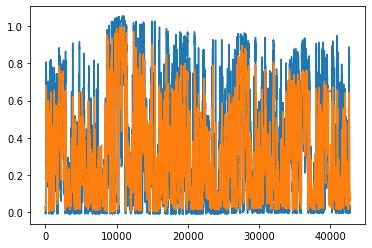

In [191]:
importance += model.feature_importance(importance_type='gain')
feats_importance = pd.DataFrame()
feats_importance['name'] = feats
feats_importance['importance'] = importance
logging.info(feats_importance.sort_values('importance', ascending=False)[:30])

plot(sub_val_df[LABEL].values)
plot(val_pred)
show()

In [192]:
model = lgb.train(params_lgb, lgb.Dataset(df_train[feats], df_train[LABEL]), num_boost_round=model.best_iteration)
model.save_model("../models/lightgbm.txt")

<h2>预测</h2>

In [193]:
pred_y = model.predict(df_test[feats])

df_test[LABEL] = pred_y * df_test["装机容量(MW)"]

df_test[['站点编号','时间','出力(MW)']].to_csv("../data/%s.csv" % datetime.now().strftime("%Y%m%d_%H%M%S"), encoding="utf-8", index=False)